In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
df = pd.read_csv('../data/processed_weather_data.csv')
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,Hour,Day,Month,Year,Weekday
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13,Partly cloudy throughout the day.,22,31,3,2006,4
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63,Partly cloudy throughout the day.,23,31,3,2006,4
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94,Partly cloudy throughout the day.,0,1,4,2006,5
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41,Partly cloudy throughout the day.,1,1,4,2006,5
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51,Partly cloudy throughout the day.,2,1,4,2006,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               96453 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Pressure (millibars)      95165 non-null  float64
 10  Daily Summary             96453 non-null  object 
 11  Hour                      96453 non-null  int64  
 12  Day                       96453 non-null  int64  
 13  Month                     96453 non-null  int64  
 14  Year  

# Preprocessing

In [4]:
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)
df = df.set_index('Formatted Date')
df = df.sort_index()

In [5]:
df['Pressure (millibars)'] = df['Pressure (millibars)'].ffill()
df = df.bfill() # Just in case there are any NaNs at the start

# Feature Engineering

In [6]:
TARGET = 'Temperature_next_hour'
df[TARGET] = df['Temperature (C)'].shift(-1)

In [7]:
df = df.iloc[:-1]  # Drop the last row with NaN target

In [8]:
# Cyclical features for Hour and Month
df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24.0)
df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24.0)
df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12.0)
df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12.0)

In [9]:
numerical_features = [
    'Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 
    'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 
    'Pressure (millibars)', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos'
]

categorical_features = ['Summary', 'Precip Type']

features = numerical_features + categorical_features
target = TARGET

In [10]:
df_model = df[features + [target]].copy()

# Chronological Data Split (80% train, 20% test)

In [11]:
split_point = int(len(df_model) * 0.8)
df_train = df_model.iloc[:split_point]
df_test = df_model.iloc[split_point:]

X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]
y_test = df_test[target]

print(f"Total data points: {len(df_model)}")
print(f"Training data points: {len(X_train)}")
print(f"Test data points: {len(X_test)}")

Total data points: 96452
Training data points: 77161
Test data points: 19291


# Create Preprocessing Pipeline

In [12]:
# Numerical transformer
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [13]:
# Categorical transformer
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [14]:
# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create and Train the Model

In [15]:
# Create a full pipeline with preprocessing and the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [16]:
# Train the model
model_pipeline.fit(X_train, y_train)

print("\nModel trained successfully.")


Model trained successfully.


In [ ]:
# Save model
joblib.dump(model_pipeline, '../models/temperature_forecast_model.joblib')

['../models/temperature_forecast_model.joblib']

# Evaluate the Model

In [18]:
# Make predictions on the test set
y_pred = model_pipeline.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("\n--- Model Evaluation ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")


--- Model Evaluation ---
Mean Absolute Error (MAE): 0.72
Root Mean Square Error (RMSE): 0.95


/Users/nghiemgiabao/Desktop/projects/Python/weather_forcast_project/venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/nghiemgiabao/Desktop/projects/Python/weather_forcast_project/venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/nghiemgiabao/Desktop/projects/Python/weather_forcast_project/venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


# Visualize the Results

In [19]:
# Create a DataFrame for plotting
df_plot = pd.DataFrame({
    'Actual Temperature': y_test,
    'Predicted Temperature': y_pred
}, index=y_test.index)


Saved visualization to temperature_forecast_comparison.png


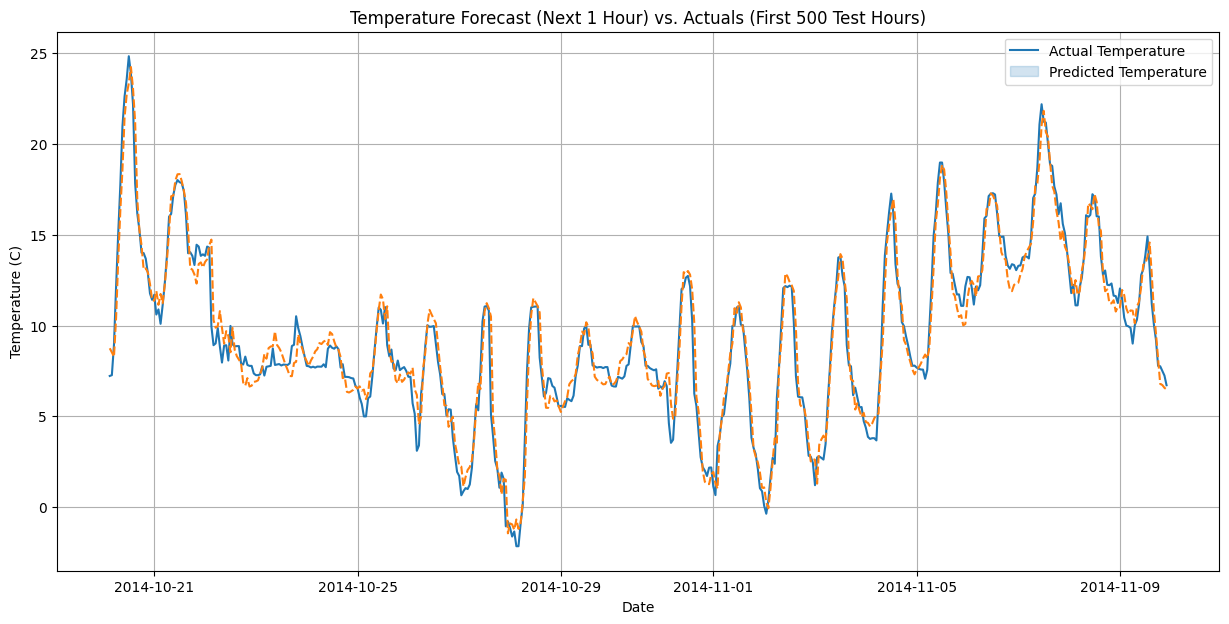

In [20]:
# Plot the first 500 hours of the test set
plt.figure(figsize=(15, 7))
sns.lineplot(data=df_plot.iloc[:500], markers=False)
plt.title('Temperature Forecast (Next 1 Hour) vs. Actuals (First 500 Test Hours)')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.legend(['Actual Temperature', 'Predicted Temperature'])
plt.grid(True)

# Save the plot BEFORE displaying or moving to next cell
plt.savefig('../charts/model/temperature_forecast_comparison.png', dpi=300, bbox_inches='tight')
print(f"\nSaved visualization to temperature_forecast_comparison.png")
plt.show()